Framework Information:
MOOSE Version:           git commit a7c0463552 on 2025-03-16
LibMesh Version:         
PETSc Version:           3.22.1
SLEPc Version:           3.22.1
Current Time:            Fri Apr 18 15:18:33 2025
Executable Timestamp:    Sat Mar 29 19:51:20 2025

Input File(s):
  /Users/windy/projects/borehole1/step2_tmp.i

Checkpoint:
  Wall Time Interval:      Every 3600 s
  User Checkpoint:         Disabled
  # Checkpoints Kept:      2
  Execute On:              TIMESTEP_END 

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          2
  Spatial Dimension:       2
  Nodes:                   3152
  Elems:                   6033
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                9456
  Num Local DOFs:          9456
  Variables:               { "porepressure" "disp_r" "disp_z" } 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "FIRST" 

Auxiliary Sy

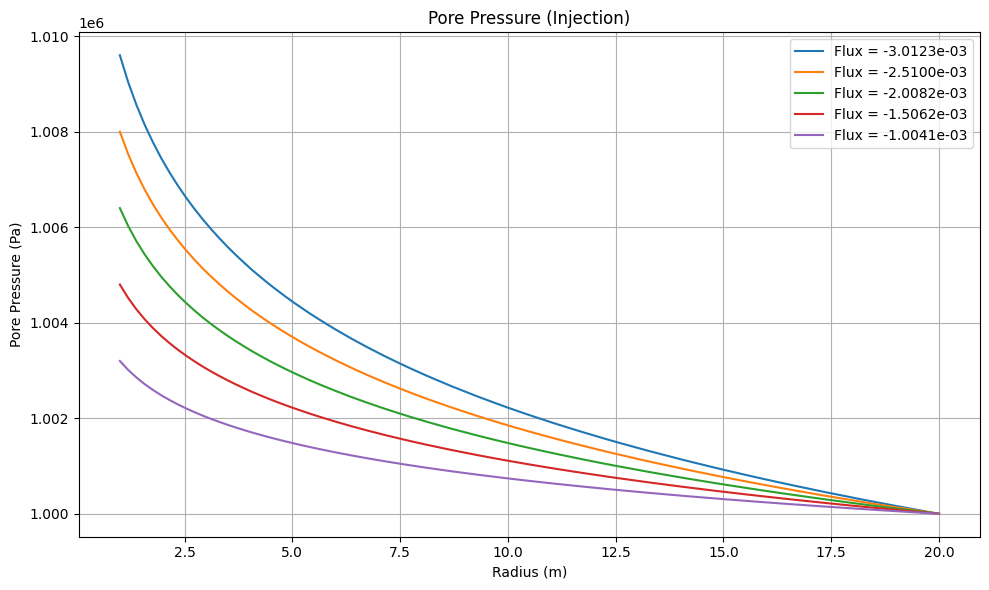

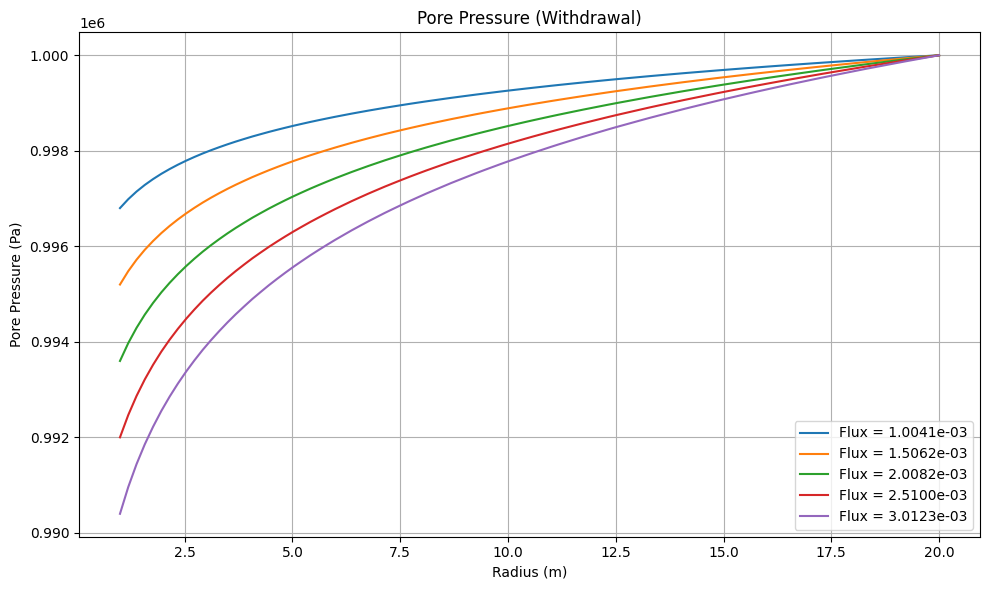

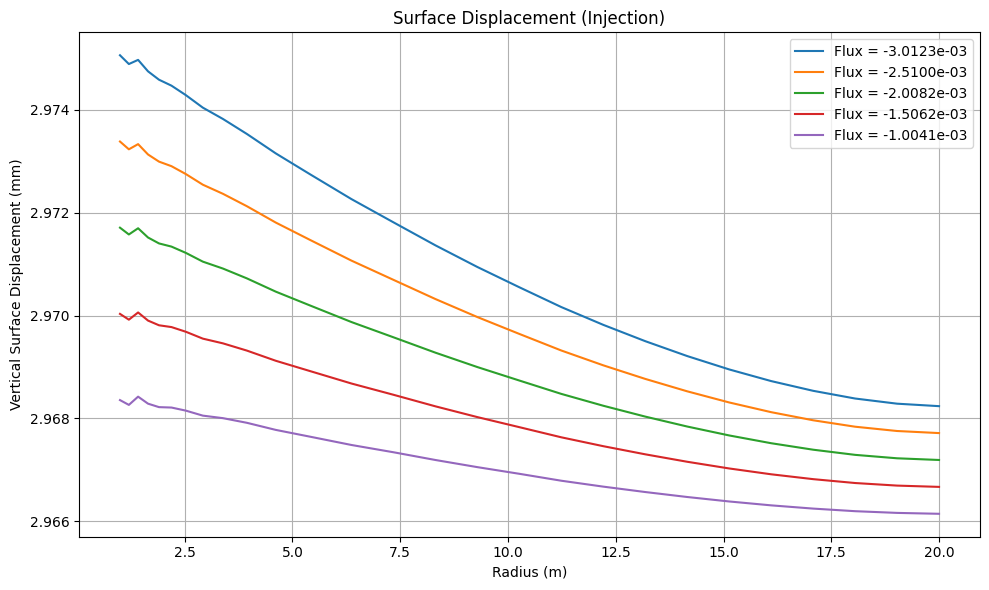

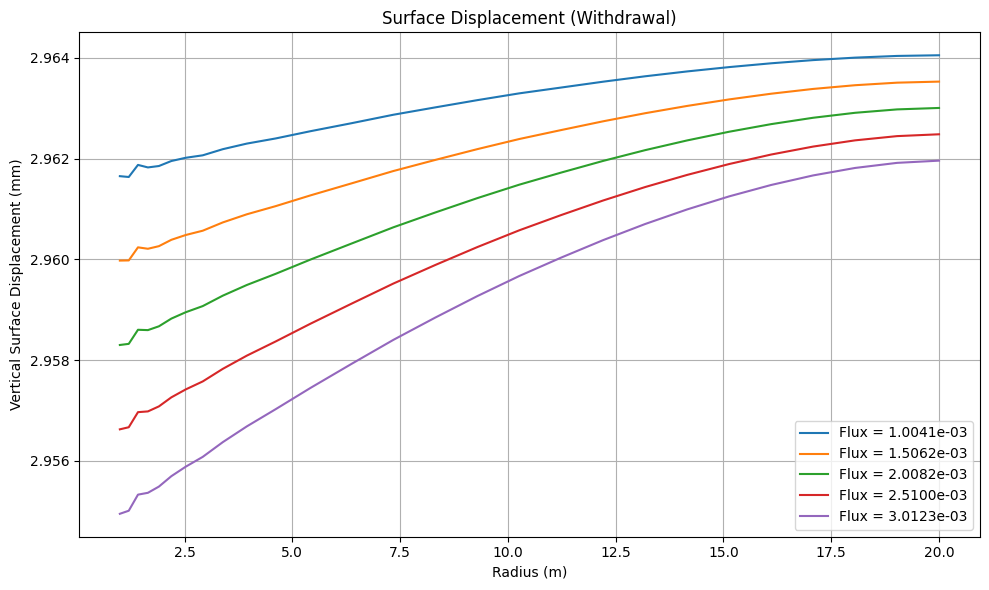

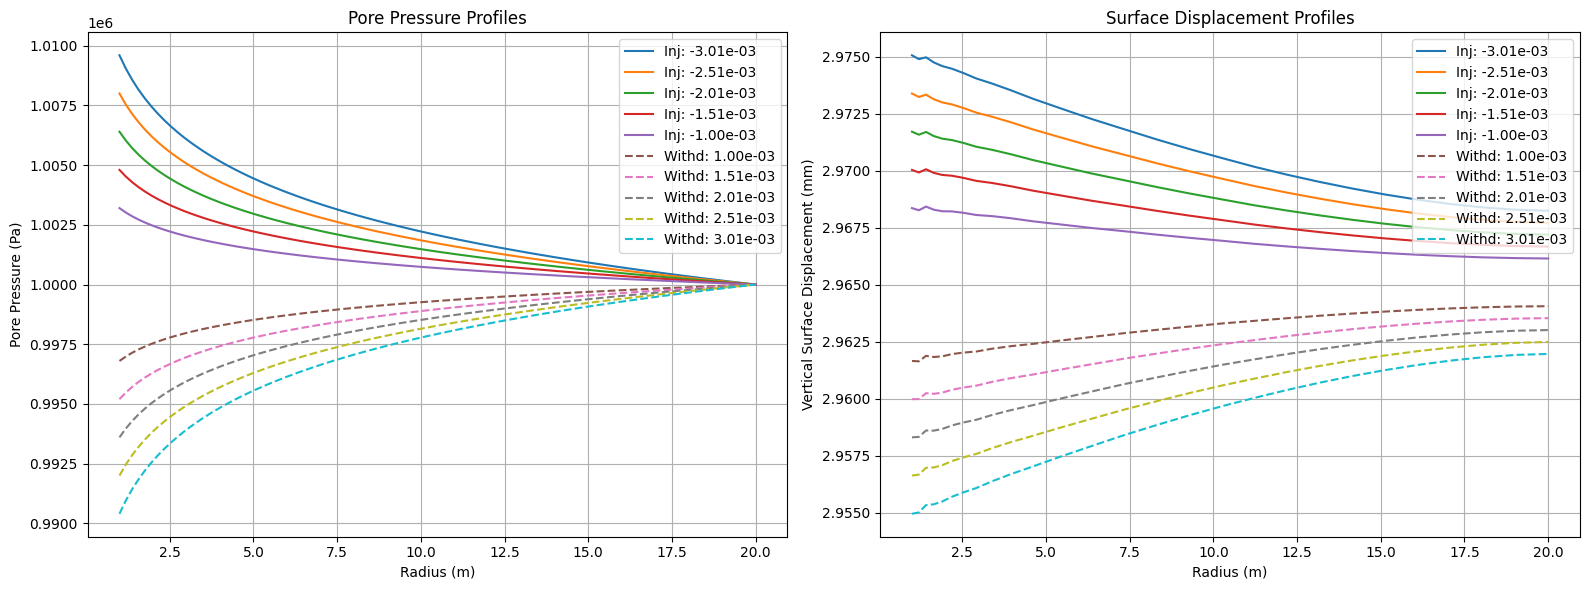

In [ ]:
"""
STEP 2
Project 1 
CEE 6755
Tomas Schmieder
"""
# this code just gives us the pressure and displacement values when we vary the flux

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import subprocess


flux_values = [
    -0.003012333566,
    -0.00250995303,
    -0.00200822503,
    -0.001506170762,
    -0.001004108536
]


input_template = "step2.i"
input_file = "step2_tmp.i"
executable = "./borehole1-opt"
pressure_csv = input_file.replace(".i", "_csv_pressure_profile_0001.csv")
disp_csv = input_file.replace(".i", "_csv_surface_disp_0001.csv")
output_dir = "sim_outputs"
os.makedirs(output_dir, exist_ok=True)


results = []

# looping over each flux value
for flux in flux_values:
    with open(input_template, "r") as f:
        input_text = f.read()

    old_flux_line = "flux_function = '-1000 * 315e-6 / (2 * pi * 1 * 20)'"
    new_flux_line = f"flux_function = '{flux:.10f}'"
    input_text = input_text.replace(old_flux_line, new_flux_line)

    with open(input_file, "w") as f:
        f.write(input_text)

    if os.path.exists(pressure_csv):
        os.remove(pressure_csv)
    if os.path.exists(disp_csv):
        os.remove(disp_csv)

    # moose
    subprocess.run([executable, "-i", input_file], check=True)

    # saving the process
    flux_tag = f"{flux:.10f}".replace(".", "p")
    pressure_out = os.path.join(output_dir, f"pressure_flux_{flux_tag}.csv")
    disp_out = os.path.join(output_dir, f"displacement_flux_{flux_tag}.csv")
    shutil.copy(pressure_csv, pressure_out)
    shutil.copy(disp_csv, disp_out)

# reiterate
for flux in flux_values:
    flux_tag = f"{flux:.10f}".replace(".", "p")
    pressure_path = os.path.join(output_dir, f"pressure_flux_{flux_tag}.csv")
    disp_path = os.path.join(output_dir, f"displacement_flux_{flux_tag}.csv")

    if os.path.exists(pressure_path) and os.path.exists(disp_path):
        df_p = pd.read_csv(pressure_path)
        df_d = pd.read_csv(disp_path)
        df = pd.merge(df_p, df_d, on="x")
        df["flux"] = flux
        combined_data = pd.concat([combined_data, df], ignore_index=True)
    else:
        print(f"Missing output for flux {flux:.4e}")



# output directory 
output_dir = "sim_outputs"
pressure_data_injection = []
pressure_data_withdrawal = []
displacement_data_injection = []
displacement_data_withdrawal = []

# iterating through the output directory and grabbing data
for fname in sorted(os.listdir(output_dir)):
    if fname.startswith("pressure_flux") and fname.endswith(".csv"):
        flux_str = fname.replace("pressure_flux_", "").replace(".csv", "").replace("p", ".")
        try:
            flux_val = float(flux_str)
        except ValueError:
            continue
        df = pd.read_csv(os.path.join(output_dir, fname))
        if flux_val < 0:
            pressure_data_injection.append((flux_val, df))
        else:
            pressure_data_withdrawal.append((flux_val, df))

    if fname.startswith("displacement_flux") and fname.endswith(".csv"):
        flux_str = fname.replace("displacement_flux_", "").replace(".csv", "").replace("p", ".")
        try:
            flux_val = float(flux_str)
        except ValueError:
            continue
        df = pd.read_csv(os.path.join(output_dir, fname))
        df = df.sort_values("x")  # sort by radius cause otherwise it messes up
        if flux_val < 0:
            displacement_data_injection.append((flux_val, df))
        else:
            displacement_data_withdrawal.append((flux_val, df))

# plotting
def plot_pressure(data, title):
    plt.figure(figsize=(10, 6))
    for flux, df in sorted(data):
        plt.plot(df["x"], df["porepressure"], label=f"Flux = {flux:.4e}")
    plt.xlabel("Radius (m)")
    plt.ylabel("Pore Pressure (Pa)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
def plot_displacement(data, title):
    plt.figure(figsize=(10, 6))
    for flux, df in sorted(data):
        plt.plot(df["x"], df["disp_z"] * 1000, label=f"Flux = {flux:.4e}")  # mm
    plt.xlabel("Radius (m)")
    plt.ylabel("Vertical Surface Displacement (mm)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_pressure(pressure_data_injection, "Pore Pressure (Injection)")
plot_pressure(pressure_data_withdrawal, "Pore Pressure (Withdrawal)")

plot_displacement(displacement_data_injection, "Surface Displacement (Injection)")
plot_displacement(displacement_data_withdrawal, "Surface Displacement (Withdrawal)")


# subplotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6))


for flux, df in sorted(pressure_data_injection):
    axs[0].plot(df["x"], df["porepressure"], label=f"Inj: {flux:.2e}", linestyle='-')
for flux, df in sorted(pressure_data_withdrawal):
    axs[0].plot(df["x"], df["porepressure"], label=f"Withd: {flux:.2e}", linestyle='--')
axs[0].set_xlabel("Radius (m)")
axs[0].set_ylabel("Pore Pressure (Pa)")
axs[0].set_title("Pore Pressure Profiles")
axs[0].grid(True)
axs[0].legend()


for flux, df in sorted(displacement_data_injection):
    axs[1].plot(df["x"], df["disp_z"] * 1000, label=f"Inj: {flux:.2e}", linestyle='-')  # mm
for flux, df in sorted(displacement_data_withdrawal):
    axs[1].plot(df["x"], df["disp_z"] * 1000, label=f"Withd: {flux:.2e}", linestyle='--')  # mm
axs[1].set_xlabel("Radius (m)")
axs[1].set_ylabel("Vertical Surface Displacement (mm)")
axs[1].set_title("Surface Displacement Profiles")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


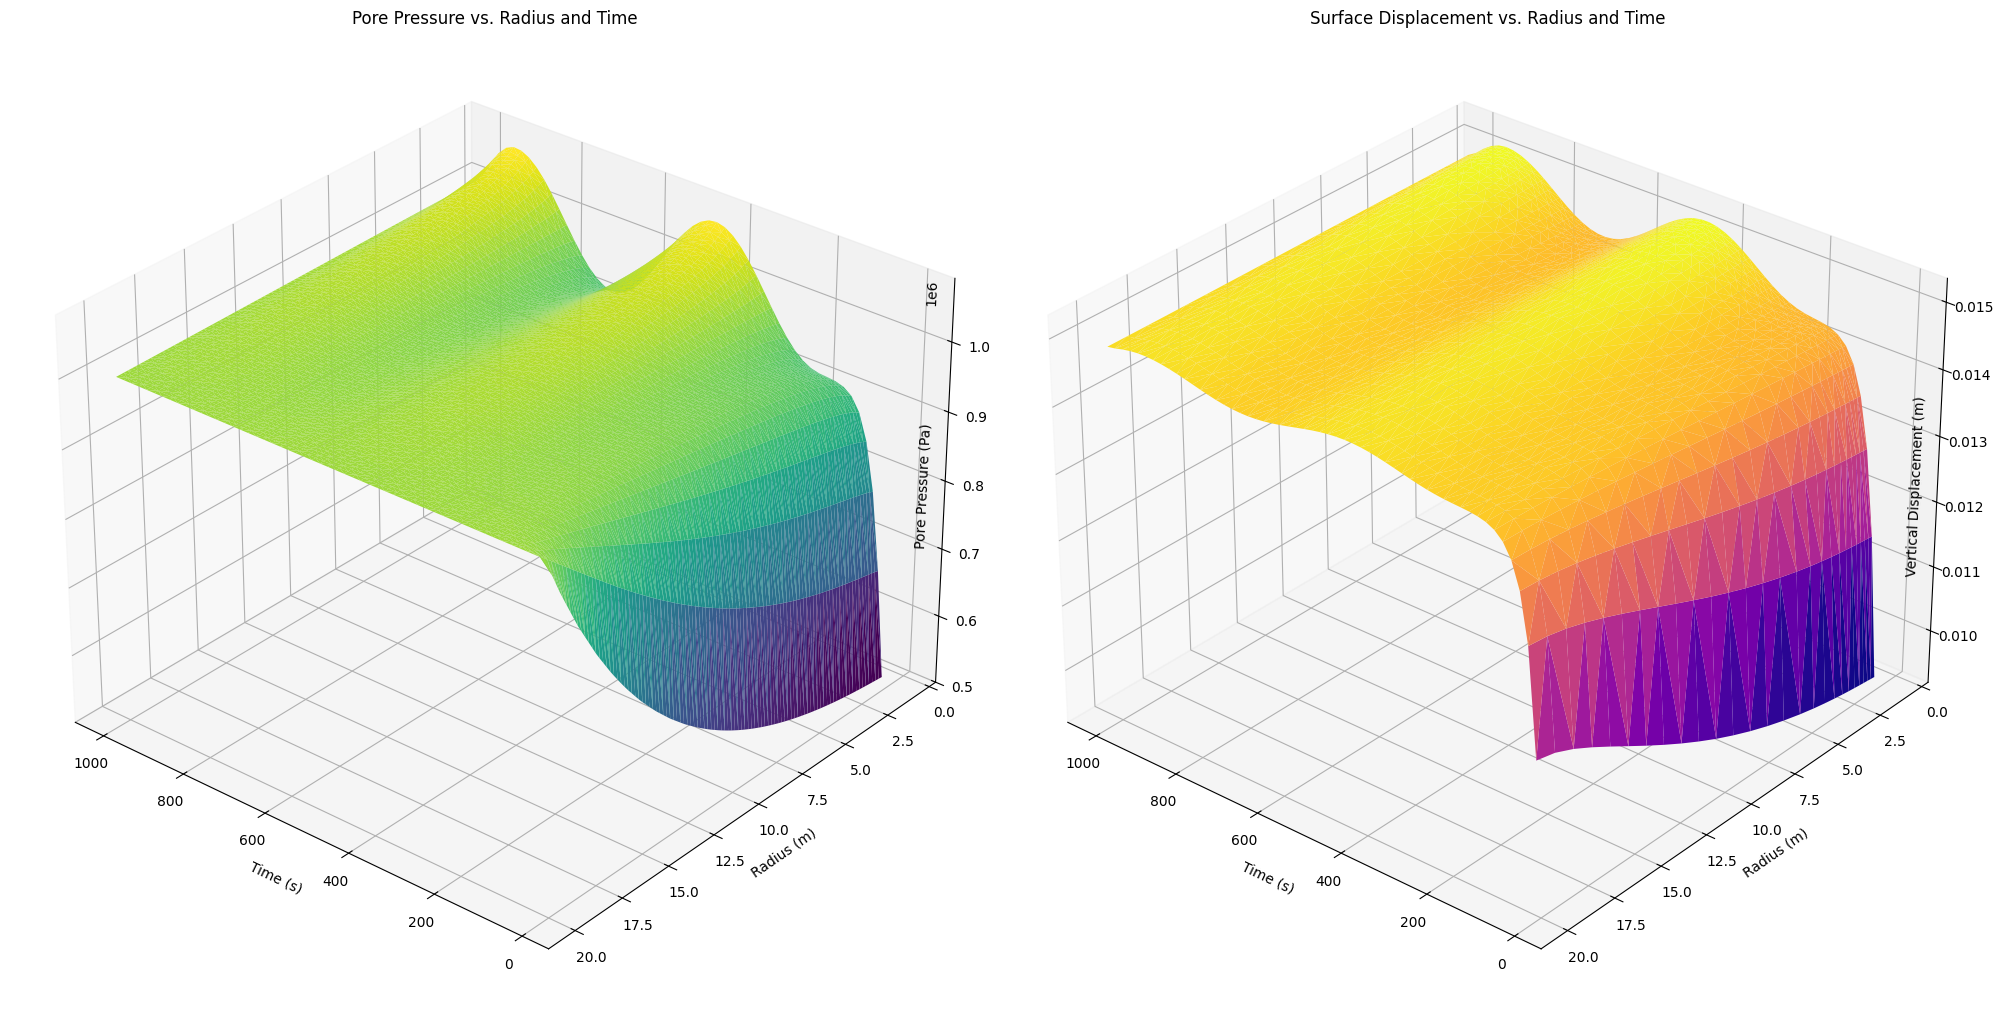

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.mplot3d import Axes3D  


# this code creates a 3D !! plot that allows us to see how pressure and displacement change over time when an injection and undergoing an injetion and withdrawal cycle

folder = "step2part/"
prefix_p = "step2part2_csv_pressure_profile_"
prefix_disp = "step2part2_csv_surface_disp_"
n_files = 54
dt = 12.5

# time vector 1000 / number of files
true_times = np.linspace(dt, 1000, n_files)
radii_p = []
times_p = []
pressures = []

# iterate over each one grab data
for i in range(1, n_files + 1):
    filename = f"{folder}{prefix_p}{i:04d}.csv"
    df = pd.read_csv(filename)
    
    time_val = true_times[i - 1]
    radii_p.extend(df["x"].values)
    times_p.extend([time_val] * len(df))
    pressures.extend(df["porepressure"].values)


radii_disp = []
times_disp = []
displacements = []

# same thing but displacements
for i in range(1, n_files + 1):
    filename = f"{folder}{prefix_disp}{i:04d}.csv"
    df = pd.read_csv(filename)
    
    time_val = true_times[i - 1]
    radii_disp.extend(df["x"].values)
    times_disp.extend([time_val] * len(df))
    displacements.extend(df["disp_z"].values)


radii_p = np.array(radii_p)
times_p = np.array(times_p)
pressures = np.array(pressures)

radii_disp = np.array(radii_disp)
times_disp = np.array(times_disp)
displacements = np.array(displacements)



fig = plt.figure(figsize=(20, 10))

# left: Pore pressure
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.view_init(elev=30, azim=130)
ax1.plot_trisurf(times_p, radii_p, pressures, cmap='viridis', linewidth=0.1)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Radius (m)")
ax1.set_zlabel("Pore Pressure (Pa)", labelpad=-30)
ax1.set_title("Pore Pressure vs. Radius and Time")

# right: Surface displacement
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.view_init(elev=30, azim=130)
ax2.plot_trisurf(times_disp, radii_disp, displacements, cmap='plasma', linewidth=0.1)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Radius (m)")
ax2.set_zlabel("Vertical Displacement (m)", labelpad=-30)
ax2.set_title("Surface Displacement vs. Radius and Time")

plt.tight_layout()
plt.show()

# HOW DO I DO UNEVEN INJECTION????????